In [4]:
#importing all the required libraries

import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler ,scale

In [5]:
#reading processed features file of NGSIM highway data
df = pd.read_csv("new_csv.csv")
df.head()


,Unnamed: 0,Vehicle_ID,Global_Time,Local_X,Local_Y,v_Vel,v_Acc,Space_Hdwy,Time_Hdwy
0,0,2,1118846980200,16.467196,35.380427,40.000000,0.000000,0.0,0.0
1,1,2,1118846980300,16.446594,39.381608,40.012349,0.123485,0.0,0.0
2,2,2,1118846980400,16.425991,43.381541,39.999855,-0.124939,0.0,0.0
3,3,2,1118846980500,16.405392,47.380780,39.992920,-0.069349,0.0,0.0
4,4,2,1118846980600,16.384804,51.379881,39.991544,-0.013759,0.0,0.0


In [6]:
#setting global time as the index of the dataframe
df = df.set_index("Global_Time")
df.head()

,Unnamed: 0,Vehicle_ID,Local_X,Local_Y,v_Vel,v_Acc,Space_Hdwy,Time_Hdwy
Global_Time,,,,,,,,
1118846980200,0,2,16.467196,35.380427,40.000000,0.000000,0.0,0.0
1118846980300,1,2,16.446594,39.381608,40.012349,0.123485,0.0,0.0
1118846980400,2,2,16.425991,43.381541,39.999855,-0.124939,0.0,0.0
1118846980500,3,2,16.405392,47.380780,39.992920,-0.069349,0.0,0.0
1118846980600,4,2,16.384804,51.379881,39.991544,-0.013759,0.0,0.0


In [7]:
#Selecting necessary features of 100000 rows.
train_df = df[["Local_X", "Local_Y","v_Vel","v_Acc","Space_Hdwy","Time_Hdwy"]].astype(float).round(decimals =2)[0:100000]
train_df.head()

,Local_X,Local_Y
Global_Time,,
1118846980200,16.47,35.38
1118846980300,16.45,39.38
1118846980400,16.43,43.38
1118846980500,16.41,47.38
1118846980600,16.38,51.38


In [8]:
#scalling the data to better generalise the model and make all features contribute in the same way.
scaler = StandardScaler()
scaler = scaler.fit(train_df)
train_df_scaled = scaler.transform(train_df)


In [9]:
train_df_scaled[0:5]

array([[-0.80645401, -1.63185053],
       [-0.80763124, -1.62505845],
       [-0.80880846, -1.61826637],
       [-0.80998569, -1.61147429],
       [-0.81175153, -1.60468221]])

In [10]:
#preparing the training input data pair of (8 past input, current input as label).
train_X, train_Y = [], []
n_future = 1
n_past = 8
for i in range(n_past, len(train_df_scaled) - n_future +1):
    train_X.append(train_df_scaled[i - n_past:i, 0:train_df.shape[1]])
    train_Y.append(train_df_scaled[i + n_future - 1:i + n_future, 0:2])

In [11]:
#printing the shape of input data size and output label size.
train_X, train_Y = np.array(train_X), np.array(train_Y)
print('train_X shape == {}.'.format(train_X.shape))
print(train_X[0:1])
print('train_Y shape == {}.'.format(train_Y.shape))
print(train_Y[0:5])

train_X shape == (99992, 8, 2).
[[[-0.80645401 -1.63185053]
  [-0.80763124 -1.62505845]
  [-0.80880846 -1.61826637]
  [-0.80998569 -1.61147429]
  [-0.81175153 -1.60468221]
  [-0.81292875 -1.59789013]
  [-0.81410598 -1.59108107]
  [-0.8152832  -1.58427201]]]
train_Y shape == (99992, 1, 2).
[[[-0.81646043 -1.57746295]]

 [[-0.81704904 -1.57067087]]

 [[-0.81881488 -1.56394671]]

 [[-0.82058071 -1.55729047]]

 [[-0.82175794 -1.55068517]]]


In [12]:
#function to calculate root mean squared error
from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [13]:
#define LSTM-DNN architecure

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=False))
#model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(train_Y.shape[2]))
model.compile(optimizer='adam', loss="mean_squared_error")
#model.compile(optimizer='rmsprop', loss=root_mean_squared_error,metrics = ["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 18,226
Trainable params: 18,226
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Defining checkpoints to store best model acoording to the minimum validation loss
checkpoint = ModelCheckpoint(
    'trajectory_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1)
history = model.fit(train_X, train_Y, epochs=8, batch_size=1, validation_split=0.1, verbose=1,callbacks=[checkpoint])


Epoch 1/8
89988/89992 [============================>.] - ETA: 0s - loss: 0.1233
Epoch 1: val_loss improved from inf to 0.04416, saving model to trajectory_model.h5
89992/89992 [==============================] - 411s 5ms/step - loss: 0.1233 - val_loss: 0.0442
Epoch 2/8
89991/89992 [============================>.] - ETA: 0s - loss: 0.1042
Epoch 2: val_loss improved from 0.04416 to 0.02346, saving model to trajectory_model.h5
89992/89992 [==============================] - 386s 4ms/step - loss: 0.1042 - val_loss: 0.0235
Epoch 3/8
89989/89992 [============================>.] - ETA: 0s - loss: 0.0983
Epoch 3: val_loss did not improve from 0.02346
89992/89992 [==============================] - 385s 4ms/step - loss: 0.0983 - val_loss: 0.0270
Epoch 4/8
89991/89992 [============================>.] - ETA: 0s - loss: 0.0941
Epoch 4: val_loss did not improve from 0.02346
89992/89992 [==============================] - 391s 4ms/step - loss: 0.0941 - val_loss: 0.0268
Epoch 5/8
89985/89992 [===========

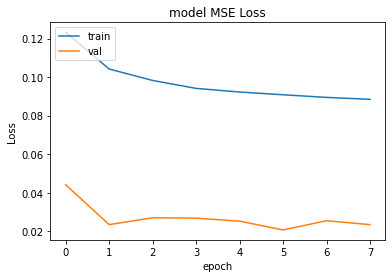

In [15]:
#plotting the MSE loss for training and validation data.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MSE Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Above graph show that the best validation MSE loss we got is 0.0207 at epoch 6 and best training loss is 0.0878 for epoch 8.

In [16]:
#prediction for last 100 input
prediction = model.predict(train_X[-100:])
prediction[0:5]

array([[ 0.03115442, -0.38111052],
       [ 0.02832498, -0.3741757 ],
       [ 0.02548135, -0.36710843],
       [ 0.02252753, -0.35990342],
       [ 0.01955203, -0.3525443 ]], dtype=float32)

In [17]:

X_pred = prediction[:,0]
Y_pred = prediction[:,1]
Y = train_Y[-100: , 0]
x = Y[:,0]
y = Y[:,1]

#print(Y[:,0])
print(X_pred[0:5])
print(Y_pred[0:5])
print(x[0:5])
print(y[0:5])

[0.03115442 0.02832498 0.02548135 0.02252753 0.01955203]
[-0.38111052 -0.3741757  -0.36710843 -0.35990342 -0.3525443 ]
[0.03879373 0.0376165  0.03585066 0.03467344 0.0329076 ]
[-0.38771134 -0.38093624 -0.37414416 -0.36735208 -0.36052604]


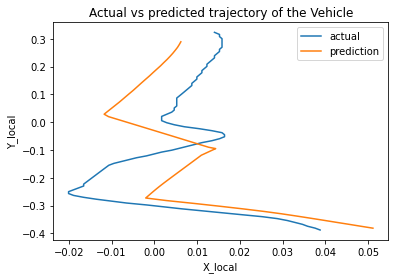

In [25]:
#plotting the actual and predictied x_local and y_local values
plt.plot(x ,y)
plt.plot(X_pred,Y_pred)
plt.legend(["actual","prediction"])
#plt.plot(X = y_pred[:,0], Y = y_pred[:,1])
plt.title("Actual vs predicted trajectory of the Vehicle")
plt.xlabel("X_local")
plt.ylabel("Y_local")
plt.show()

Above graph shows the performace of our LSTM-DNN model, It can be seen that it is able to predict the shape of vehicle trajectory in a short span of 100 frames to.